# Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from collections import defaultdict

from utils import tools, preprocessing, models, eval, plotting, hpo

2025-10-13 19:17:36.446877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760375856.468484 1731823 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760375856.475392 1731823 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760375856.492605 1731823 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760375856.492627 1731823 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760375856.492629 1731823 computation_placer.cc:177] computation placer alr

In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.1.4
Numpy version: 1.26.4
Tensorflow version: 2.19.0


In [3]:
config = tools.load_config('configs/config_wind.yaml')
tools.initialize_gpu(7)

In [4]:
# paths
data = 'synth_wind/clientA'
dataset_name = 'synth_wind_openmeteo'
file = 'synth_00161.csv'
target_col = 'power'

# model params
model_name = 'tcn-gru'
output_dim = 1 # in hours
epochs = 10
batch_size = 32
make_callbacks = False
shuffle = True
n_cnn_layers = 5
n_rnn_layers = 1
n_layers = 2
kernel_size = 3
filters = 64
units = 64
dropout = 0.1
learning_rate = 0.0002
# fl params
strategy = 'fedavg'

# data params
freq = '1h'
lookback = 48 # in hours
horizon = output_dim # in hours
step_size = 1
# data split params
t_0 = None#'09:00' # forecast run time (UTC)
scale_y = False
lag_in_col = False

# more params
evaluate_on_all_test_data = True
study_name = None#f'fl_a-{strategy}_d-{data}_m-{model_name}_out-{output_dim}_freq-{freq}'
get_physical_persistence = True

In [5]:
# config related
config['data']['freq'] = freq
config['model']['name'] = model_name
config['model']['output_dim'] = output_dim
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config['model']['lr'] = learning_rate
config = tools.handle_freq(config=config)
freq = config['data']['freq']
output_dim = config['model']['output_dim']
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config['model']['step_size'] = step_size
config['data']['lag_in_col'] = lag_in_col
config['model']['rnn']['n_rnn_layers'] = n_rnn_layers
config['model']['rnn']['units'] = units
config['model']['cnn']['n_cnn_layers'] = n_cnn_layers
config['model']['cnn']['kernel_size'] = kernel_size
config['model']['cnn']['filters'] = filters
config['model']['shuffle'] = shuffle
params = config.get('params', {})
park_id = file.split('.')[0][-5:]
key = f'{data.split("/")[1]}_{file}'

In [6]:
# read data

known, observed, static = preprocessing.get_features(dataset_name=data, config=config)
rel_features = known + observed
dfs = preprocessing.get_data(dataset_name=dataset_name,
                             config=config,
                             data_dir='data',
                             freq=freq,
                             rel_features=rel_features,
                             target_col=target_col)
df = dfs[key]

In [7]:
test_start = pd.Timestamp(config['data']['test_start'])
if 'lag_known_features' in config['params']:
    observed.extend(config['params']['lag_known_features'])
prepared_data, df = preprocessing.pipeline(data=df,
                                           config=config,
                                           known_cols=known,
                                           observed_cols=observed,
                                           static_cols=static,
                                           test_start=test_start,
                                           target_col=target_col)
X_train, y_train = prepared_data['X_train'], prepared_data['y_train'],
X_test, y_test = prepared_data['X_test'], prepared_data['y_test']
index_train = prepared_data['index_train']
index_test = prepared_data['index_test']
scaler_y = prepared_data['scalers']['y']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12648, 1, 1) (12648, 1) (3000, 1, 1) (3000, 1)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15648 entries, 2023-07-24 00:00:00+00:00 to 2025-05-05 23:00:00+00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   power          15648 non-null  float64
 1   wind_speed_t1  15648 non-null  float64
dtypes: float64(2)
memory usage: 882.8 KB


In [9]:
config['model']['fl'] = False
study = hpo.load_study(config['hpo']['studies_path'], study_name)
hyperparameters = hpo.get_hyperparameters(config=config, study=study)
hyperparameters['epochs'] = epochs#config['model']['epochs']
hyperparameters['batch_size'] = batch_size#config['model']['epochs']

config['model']['name'] = model_name

config['model']['feature_dim'] = tools.get_feature_dim(X_train)
model = models.get_model(config=config,
                         hyperparameters=hyperparameters)

I0000 00:00:1760375866.613882 1731823 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46731 MB memory:  -> device: 7, name: NVIDIA RTX A6000, pci bus id: 0000:e1:00.0, compute capability: 8.6


In [10]:
hyperparameters

{'shuffle': True,
 'batch_size': 32,
 'epochs': 10,
 'lr': 0.0002,
 'filters': 64,
 'kernel_size': 3,
 'n_cnn_layers': 5,
 'increase_filters': False,
 'dropout': 0.1,
 'units': 64,
 'n_rnn_layers': 1}

In [11]:
#model.summary()

In [12]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test),
    shuffle = hyperparameters['shuffle']
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/10


I0000 00:00:1760375869.400346 1732692 cuda_dnn.cc:529] Loaded cuDNN version 90800


396/396 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0014 - mae: 0.0148 - r2: 0.5564 - rmse: 0.0361 - val_loss: 2.1610e-05 - val_mae: 0.0013 - val_r2: 0.9935 - val_rmse: 0.0046
Epoch 2/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 7.2790e-05 - mae: 0.0044 - r2: 0.9787 - rmse: 0.0085 - val_loss: 1.3595e-05 - val_mae: 0.0020 - val_r2: 0.9959 - val_rmse: 0.0037
Epoch 3/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 3.3658e-05 - mae: 0.0030 - r2: 0.9893 - rmse: 0.0058 - val_loss: 4.1161e-06 - val_mae: 0.0015 - val_r2: 0.9988 - val_rmse: 0.0020
Epoch 4/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 3.4394e-05 - mae: 0.0030 - r2: 0.9888 - rmse: 0.0059 - val_loss: 7.4289e-06 - val_mae: 0.0019 - val_r2: 0.9978 - val_rmse: 0.0027
Epoch 5/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 3.3127e-05 - mae: 0.0031 - r2: 0.9889 - rmse: 0.0057 - val_loss: 9.4909e-06 - val_mae: 0.0026 - val_r2: 0.9972 - val_rmse: 0.0031
Epoch 6/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss

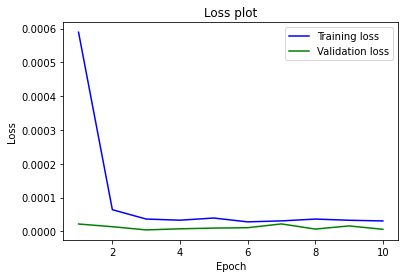

In [13]:
plotting.plot_training(history=history,
                       validation=True,
                       save_name=None)

In [14]:
y_true, y_pred = tools.get_y(X_test=X_test,
                             y_test=y_test,
                             scaler_y=scaler_y,
                             model=model)
df_pred = tools.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = tools.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

y_pers = eval.persistence(y=df[target_col],
                          horizon=horizon,
                          from_date=str(test_start.date()))
test_indices = None
if len(index_test.shape) != 1:
    test_indices = index_test[:,0]
    if output_dim == 1:
        test_indices = np.array(list(set(index_test[:,2])))
        test_indices.sort()
        y_pers = y_pers[test_indices]
        y_pers_raw = pd.DataFrame(index_test, columns=list(df.index.names))
        y_pers = y_pers_raw.merge(y_pers.to_frame(), how='left', on='timestamp')['power'].values
        test_indices = None

y_pers = preprocessing.make_windows(data=y_pers,
                                  seq_len=y_pred.shape[-1],
                                  step_size=1,
                                  indices=test_indices)

df_pers = tools.y_to_df(y=y_pers,
                        output_dim=output_dim,
                        horizon=horizon,
                        index=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

pers = {}
pers['Persistence'] = df_pers

if get_physical_persistence:
    if 'wind' in config['data']['synth_path']:
        y_synth = eval.get_synth_wind(synth_dir=config['data']['synth_path'],
                                park_id=park_id,
                                from_date=index_test[0],
                                to_date=df.index[-1],
                                params=params,)
    y_synth = preprocessing.make_windows(data=y_synth,
                                           seq_len=y_pred.shape[-1],
                                           step_size=1, # has to be 1 filtering goes over t_0 in df_synth
                                           indices=test_indices)
    df_synth = tools.y_to_df(y=y_synth,
                            output_dim=output_dim,
                            horizon=horizon,
                            index=index_test,
                            t_0=None if evaluate_on_all_test_data else t_0)
    pers['Synth'] = df_synth

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [15]:
results = eval.evaluate_models(pred=df_pred,
                               true=df_true,
                               persistence=pers,
                               main_model_name=model_name)

In [16]:
results

,R^2,RMSE,MAE,Skill
Models,,,,
tcn-gru,0.998224,0.002436,0.001372,0.920377
Persistence,0.719870,0.030595,0.011837,0.000000
Synth,-0.126187,0.061344,0.023363,-1.005051


Forecast run at 2025-04-05 10:00:00+00:00 

R^2: nan
RMSE: 0.00011376093705498316
MAE: 0.00011376093705498316


/home/viktorwalter/Work/forecasting_framework/frcst/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


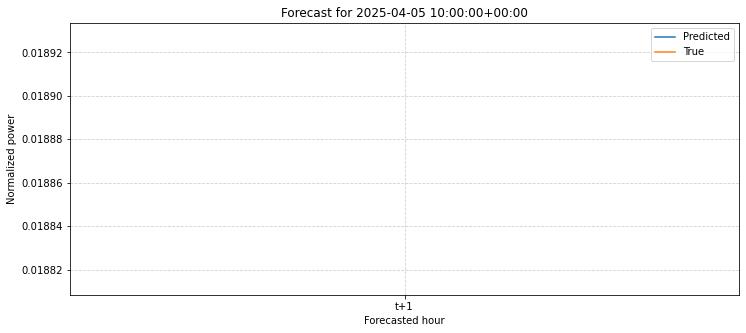

In [17]:
#date = '2025-01-04'
#datetime = pd.Timestamp(f'{date} {t_0}:00+00:00')
datetime = np.random.choice(df_pred.index)

print(f'Forecast run at {datetime}', '\n')

plotting.plot_forecast(y_pred=df_pred.loc[datetime].values,
                       y_true=df_true.loc[datetime].values,
                       horizon=horizon,
                       date=str(datetime),
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

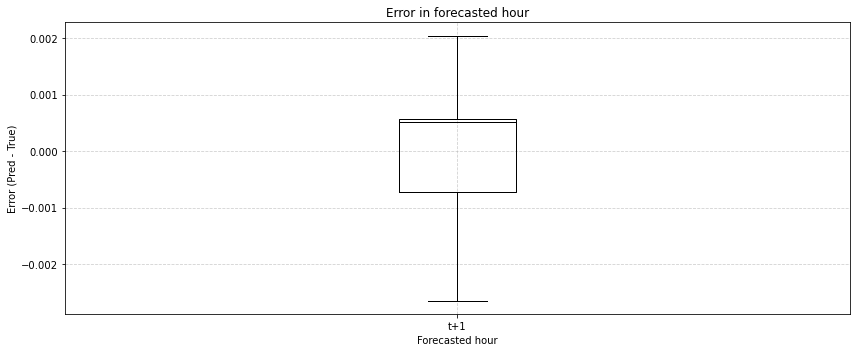

In [18]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

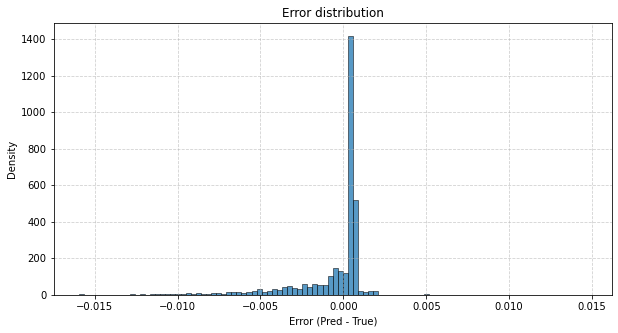

In [19]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 t_0=t_0,
                                 bins=100,
                                 grid=True)

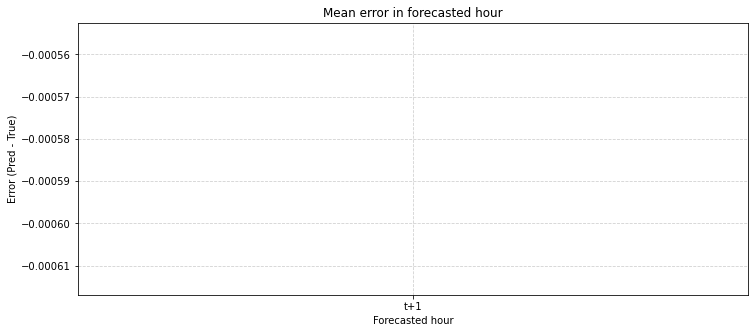

In [20]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)